# LM7805 Analysis and Simulation

By Shuo Chen (chenshuo_at_chenshuo.com)

Latest notebook: https://github.com/chenshuo/notes/blob/master/notebooks/LM7805.ipynb

Comments and discussions: https://github.com/chenshuo/notes/discussions

Series of analysis & simulation of IC regulator designed in 1970s:

1. [μA78L05](https://chenshuo.github.io/notes/UA78L05)
2. [LM7805](https://chenshuo.github.io/notes/LM7805) <- This page
3. [TL431](https://chenshuo.github.io/notes/TL431)

In [1]:
%matplotlib inline

from math import exp, log, log10

# NgSpice
import ngspyce as ng

import numpy as np
from matplotlib import pyplot as plt

def para(r1, r2):
    return (r1*r2) / (r1 + r2)

def print_op(print_base_current=True, print_emitter_current=False):
  op = ng.operating_point()
  for k in sorted(op.keys()):
    if k[0] == '@' or '#branch' in k:
        if '[is]' in k:
            continue
        if '[ib]' in k and not print_base_current:
            continue
        if '[ie]' in k and not print_emitter_current:
            continue

        print('%10s = %8.2f uA' % (k, 1e6*op[k][0]))
    else:
        print('%10s = %8.2f mV' % (k, 1e3*op[k][0]))

In [2]:
# Circuitikz
# pip install git+https://github.com/mkrphys/ipython-tikzmagic.git

%load_ext tikzmagic

## LM7805 != μA7805

https://www.righto.com/2014/09/reverse-engineering-counterfeit-7805.html

In most if not all practices, LM7805 and μA7805 can be used interchangeablly, but their internal schematic are different.
[Ken Shirriff suspects](https://www.righto.com/2014/09/reverse-engineering-counterfeit-7805.html) "manufacturers are constrained by patents, so they use the part numbers they want on the devices they can make."

Two common designs:
1. LM7805 $=$ LM340 from National semiconductor. based on [LM109/LM309](https://www.ti.com/lit/an/snva512b/snva512b.pdf) by Robert Widlar in 1969.
2. μA7805 from Fairchild semiconductor, debut in 1971.

The obvious difference is their reference voltage, μA7805 has 4 $V_\mathrm{BE}$ on its reference voltage, after temperature compensation $V_\mathrm{REF} \approx 4 \times V_\mathrm{g0}\approx 4.8$V.
While LM7805 has 3 $V_\mathrm{BE}$ on its reference voltage, so after temperature compensation $V_\mathrm{REF} \approx 3 \times V_\mathrm{g0}\approx 3.6$V.

### LM7805

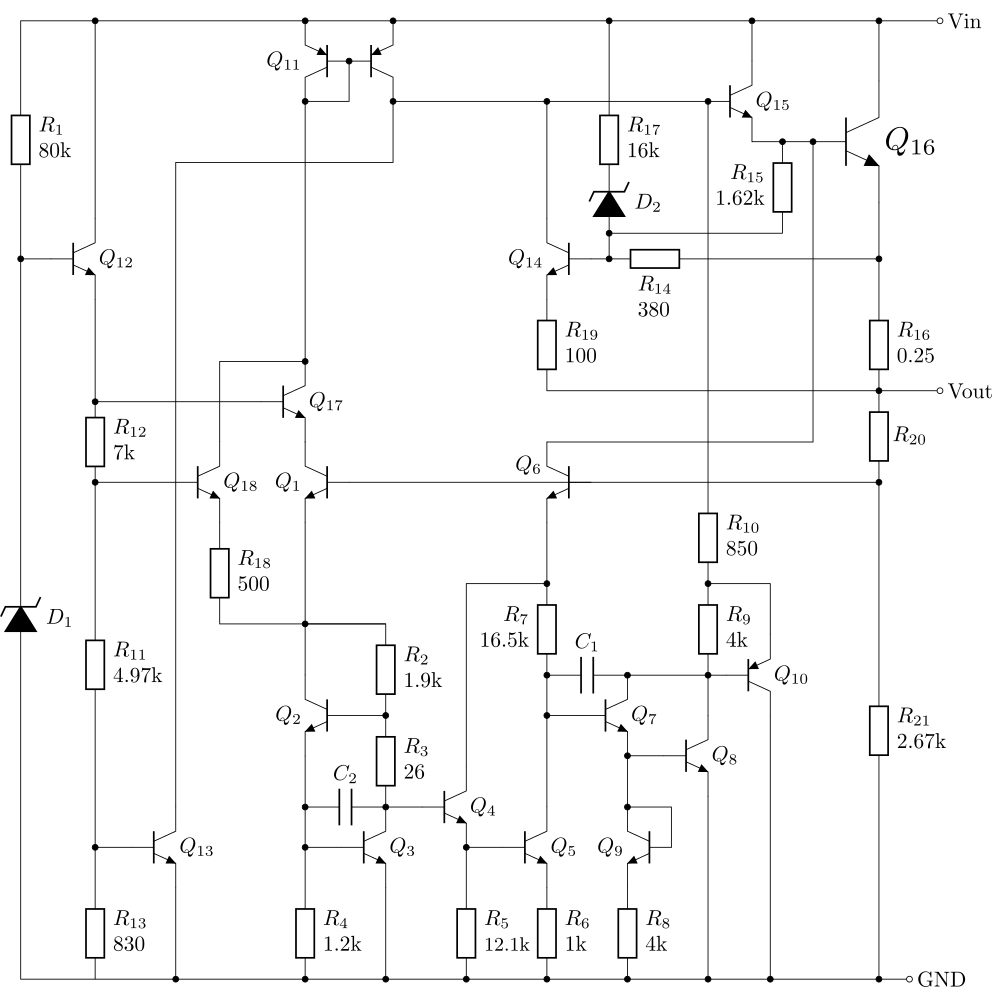

> This is a vector graphic, right click and open it in a new tab, then zoom in as you need.

### μA7805

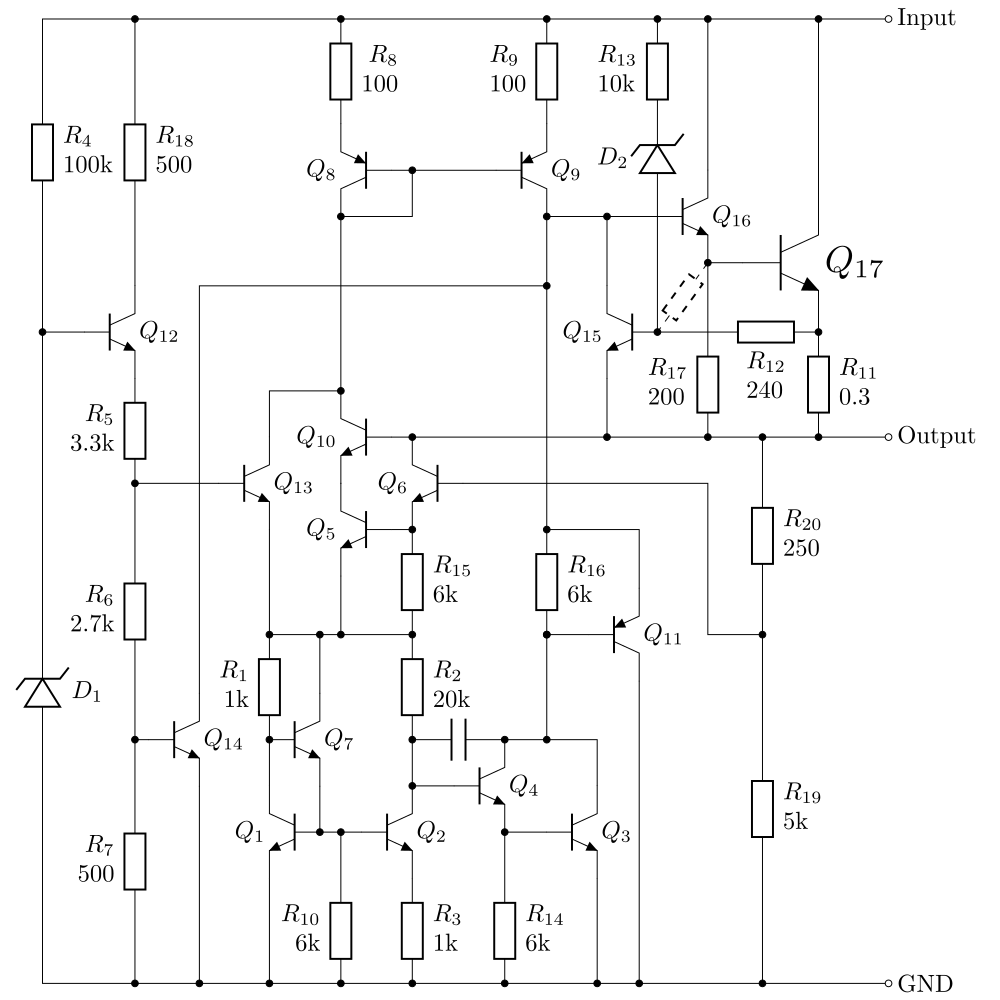

A few notes:

1. Unlabelled $R_{21}$ between base of $Q_{15}$ and emitter of $Q_{16}$ didn't exist in 1971 or 1973 datasheets from Fairchild. So it's drawn in dashed lines.
2. Value of $R_{16}$ changes between 2kΩ and 6kΩ in different versions of datasheets, the value probably doesn't matter too much though.
3. $R_{20}=250$Ω is for 5V output, from this we can estimate the interal reference voltage at base of $Q_6$ is $\dfrac{5}{5+0.25}\times 5.0 = 4.762$V.

## μA7805

https://www.ti.com/lit/ds/symlink/ua78.pdf


### Simplified schematic

Adapted from 1974 Fairchild [_Voltage Regulator Applications Handbook_](https://bitsavers.org/components/fairchild/_dataBooks/1974_Fairchild_Voltage_Regulator_Applications_Handbook.pdf), p.2-4

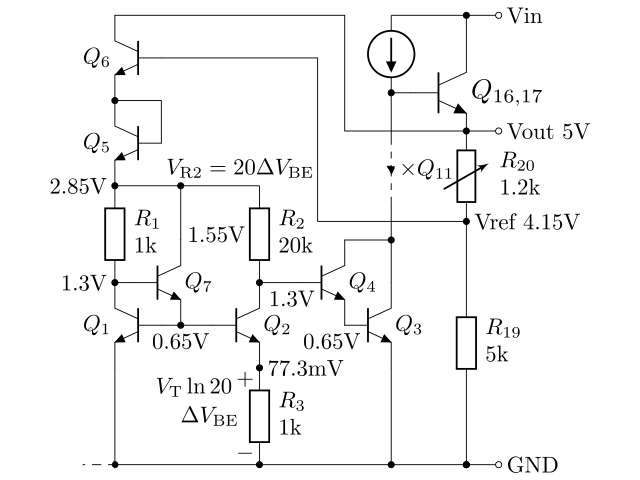

Brief analysis:

The main part of the bandgap reference: $Q_1$, $Q_2$ generates $\Delta V_\mathrm{BE}$ on $R_3$, and magnify it on $R_2$.
$R_2$ is critical, as the voltage on it $V_\mathrm{R2}$ has  positive tempco, to cancel negative tempco of 4 $V_\mathrm{BE}$s.

7805 works in a different way than [μA78L05](https://chenshuo.github.io/notes/UA78L05), the latter is traditional: generating stable reference voltage usng bandgap circuit, then comparing output voltage against it.

In 7805, the bandgap reference works ["backwards"](https://www.righto.com/2014/09/reverse-engineering-counterfeit-7805.html), the whole chip can be viewed as a bandgap reference.
The "purpose" of the circuit, including its external load, is maintaining a stable voltage at the base of $Q_6$, which according to literature, it is supposed to be 4.8V, that is $4 \times V_\mathrm{g0}$.
What we really want from this circuit, is its "side-effect" of delivering stable 5V voltage output at Vout pin.
In other words, the error amplifier made of $Q_3, Q_4, \mathrm{and} Q_{11}$, and the output pass transistors $Q_{16}$ and $Q_{17}$ are all part of the feedback look of the bandgap reference, whose error singal is from collector of $Q_2$.

Estimating quiescent operating point:

1. Assuming all $V_\mathrm{BE}\approx 0.65$V.
1. $V_\mathrm{Q1B} = V_\mathrm{Q3B} =0.65$V, $V_\mathrm{Q7B} = V_\mathrm{Q4B} =1.3$V
1. $V_\mathrm{R1} = V_\mathrm{R2}\ \Rightarrow\ I_\mathrm{R1} \cdot R_1 = I_\mathrm{R2} \cdot R_2$
1. $I_\mathrm{R1} = \dfrac{R_2}{R_1}I_\mathrm{R2} = 20 I_\mathrm{R1}$
1. $I_\mathrm{R1} \approx I_\mathrm{C1}$, $I_\mathrm{R2} \approx I_\mathrm{C2}$, so $I_\mathrm{C1} \approx 20 I_\mathrm{C2}$
1. $V_\mathrm{R3} = \Delta V_\mathrm{BE} = V_\mathrm{BE1} - V_\mathrm{BE2} = V_\mathrm{T} \ln \dfrac{I_\mathrm{C1}}{I_\mathrm{C2}} \approx V_\mathrm{T} \ln 20 \approx 3 V_\mathrm{T} = 77.3$mV
1. $V_\mathrm{R2} = \dfrac{R_2}{R_3} \Delta V_\mathrm{BE} = 20 \Delta V_\mathrm{BE} \approx 1.546$V
1. $V_\mathrm{Q5E} = V_\mathrm{R2} + V_\mathrm{Q4B} \approx 1.55 + 1.30 = 2.85$V
1. $V_\mathrm{REF} = V_\mathrm{Q6B} = V_\mathrm{Q5E} + V_\mathrm{BE5} + V_\mathrm{BE6} \approx 2.85 + 0.65 \times 2 = 4.15$V


### SPICE model

I couldn't find a SPICE model, so I made my own for helping analysis.

```SPICE
  * UA7805 DC path model
  V1    vin  0   10V
  Rload out  0   100

  * Bandgap reference
  R1  q5e  q1c      1k
  Q1  q1c  q1b 0    NPN
  Q7  q5e  q1c q1b  NPN
  R10 q1b  0        6k
  Q2  q4b  q1b r3   NPN
  R3  r3   0        1k
  R2  q5e  q4b      20k

  * Error amplifier
  Q4  q11b q4b  q3b  NPN
  Q3  q11b q3b  0    NPN
  R14 q3b  0         6k
  Q11 0    q11b q9c  PNP
  R16 q9c  q11b      6k

  * Current mirror
  R8  vin  q8e 100
  R9  vin  q9e 100
  Q8  q8b  q8b q8e  PNP
  Q9  q9c  q8b q9e  PNP

  * Feedback
  Q10 q8b  out q10e NPN
  Q5  q10e q6e q5e  NPN
  Q6  out  ref q6e  NPN
  R15 q6e  q5e      6k
  R19 ref  0        5k
  R20 out  ref      1.25k

  * Output
  Q16 vin  q9c  q17b NPN
  Q17 vin  q17b q17e NPN 10
  R11 q17e out       0.3
  R17 q17b out       200

  * Start-up
  R4  vin  q12b      100k
  D1  0    q12b      DZ
  R18 vin  q12c      500
  Q12 q12c q12b q12e NPN
  R5  q12e q13b      3.3k
  R6  q13b q14b      2.7k
  R7  q14b 0         500
  Q13 q8b  q13b q5e  NPN
  
  .MODEL NPN NPN( IS=5f BF=80  VAF=100 CJC=1P CJE=2P )
  .MODEL PNP PNP( IS=2f BF=60  VAF=50  CJC=1P CJE=2P )
  .MODEL DZ D(BV=5.6)

* .options savecurrents
```

This model doesn't have output current limiting or over voltage protection circuits.

In [49]:
ng.circ('''
  V1    vin  0   10V
  Rload out  0   100

  * Bandgap reference
  R1  q5e  q1c      1k
  Q1  q1c  q1b 0    NPN
  Q7  q5e  q1c q1b  NPN
  R10 q1b  0        6k
  Q2  q4b  q1b r3   NPN
  R3  r3   0        1k
  R2  q5e  q4b      20k

  * Error amplifier
  Q4  q11b q4b  q3b  NPN
  Q3  q11b q3b  0    NPN
  R14 q3b  0         6k
  Q11 0    q11b q9c  PNP
  R16 q9c  q11b      6k

  * Current mirror
  R8  vin  q8e 100
  R9  vin  q9e 100
  Q8  q8b  q8b q8e  PNP
  Q9  q9c  q8b q9e  PNP

  * Feedback
  Q10 q8b  out q10e NPN
  Q5  q10e q6e q5e  NPN
  Q6  out  ref q6e  NPN
  R15 q6e  q5e      6k
  R19 ref  0        5k
  R20 out  ref      1.25k

  * Output
  Q16 vin  q9c  q17b NPN
  Q17 vin  q17b q17e NPN 10
  R11 q17e out       0.3
  R17 q17b out       200

  * Start-up
  R4  vin  q12b      100k
  D1  0    q12b      DZ
  R18 vin  q12c      500
  Q12 q12c q12b q12e NPN
  R5  q12e q13b      3.3k
  R6  q13b q14b      2.7k
  R7  q14b 0         500
  Q13 q8b  q13b q5e  NPN
  
  * .options savecurrents
.MODEL NPN NPN( IS=5f BF=80  VAF=100 CJC=1P CJE=2P )
.MODEL PNP PNP( IS=2f BF=60  VAF=50  CJC=1P CJE=2P )
.MODEL DZ D(BV=5.6)
''')
op = print_op()

ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver


       out =  5036.03 mV
      q10e =  4353.91 mV
      q11b =  5771.47 mV
      q12b =  5514.02 mV
      q12c =  9631.36 mV
      q12e =  4849.91 mV
      q13b =  2387.65 mV
      q14b =   373.07 mV
      q17b =  5762.40 mV
      q17e =  5050.33 mV
       q1b =   681.96 mV
       q1c =  1301.99 mV
       q3b =   587.34 mV
       q4b =  1198.93 mV
       q5e =  2723.81 mV
       q6e =  3407.03 mV
       q8b =  9148.40 mV
       q8e =  9854.43 mV
       q9c =  6471.34 mV
       q9e =  9853.30 mV
        r3 =    76.02 mV
       ref =  4027.21 mV
 v1#branch = -54970.62 uA
       vin = 10000.00 mV


In [56]:
print('Bias current = %.2f mA' % (54.971 - 50.36))

Bias current = 4.61 mA


The following is the simulation result of DC operating point.

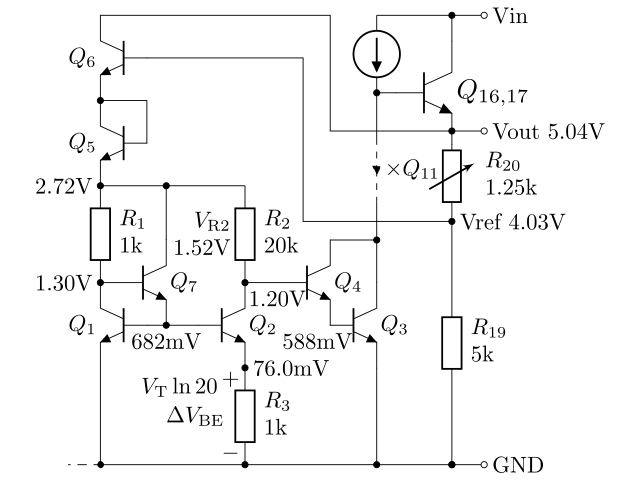

In [39]:
%%tikz -p circuitikz -s 640,480 -f svg
\newcommand{\uv}[1]{\ensuremath{V_\mathrm{#1}}}

\ctikzset{european resistors, american currents, american voltages, transistors/arrow pos=end, bipoles/length=1.2cm}
\usetikzlibrary {math}
\tikzmath{\x = 0.6;}

\draw (0, 0) coordinate(I)
  to [R, n=R2, l2={$R_2$ and 20k}, bipoles/length=1.0cm] ++(0, -1.5)
  node [npn, anchor=C] (Q2) {$Q_2$};
\draw (Q2.E) node [circ] {} node [right] {76.0mV}
  to [R, n=R3, l2={$R_3$ and 1k}, v={$\Delta\uv{BE}$}, bipoles/length=1.0cm] ++(0, -1.5)
  coordinate (G)
  node [circ] {};
\draw (Q2.B) to [short] ++(-0.8, 0)
  node [npn, anchor=B, xscale=-1] (Q1) {\ctikzflipx{$Q_1$}};
\draw (Q1.C) to [short, *-] ++(0.3, 0) node [npn, anchor=B] (Q7) {$Q_7$};
\draw (Q7.E) node [circ] {};
\draw (Q7.C) to [short, -*] (Q7.C|-I);

% \draw (Q1.C) to [R, l2_={$R_1$ and 1k}, bipoles/length=1.0cm] (Q1.C |- I) -- (I);
\draw (Q1.C|-I) to [R, l2={$R_1$ and 1k}, bipoles/length=1.0cm] ++(0, -1.5) -- (Q1.C);
\draw (Q1.C|-I) -- (I);
\draw (Q1.E) |- (G);
\draw [dashed] (Q1.E|-G) to [short, *-] ++(-0.5, 0);

\draw (Q2.C) to [short, *-] ++(0.6, 0)
  node [npn, anchor=B] (Q4) {$Q_4$};
% \draw (Q3.C) to [short, -*] (Q3.C |- I) -- (I);
%\draw (Q3.C |- G) to [short, -o] ++(0.5, 0) node [right] {GND};
%\draw (Q3.C |- I) to [short, -o] ++(0.5, 0) node [right] {Vref};
% \draw (Q3.C) ++ (0.1, 0.1) node [right] {$\uv{BE3} + \displaystyle \frac{R_2}{R_3} \Delta \uv{BE}$};

\draw (Q4.E)
  node [npn, anchor=B] (Q3) {$Q_3$};
\draw (Q3.E) to [short, -*] (Q3.E |- G) -- (G);
\draw (Q3.C) to [short, -*] (Q3.C |- Q4.C) -- (Q4.C);

\draw (Q1.C |- I) node [circ] {}
  node [npn, anchor=E, xscale=-1] (Q5) {\ctikzflipx{$Q_5$}};
\draw (Q5.B) |- (Q5.C);

\draw (Q5.C) node [circ] {}
  node [npn, anchor=E, xscale=-1] (Q6) {\ctikzflipx{$Q_6$}};

\draw (Q6.C-|Q3.C) coordinate (T) to [I] ++(0, -1.2)
  to [short, *-] ++(0.3, 0)
  node [scale=1.2, npn, anchor=B] (Q17) {$Q_{16, 17}$};
\draw (Q17.C) to [short, -*] (Q17.C|-T)
  to [short, -o] ++(0.5, 0) node [right] {Vin};
\draw (Q17.C|-T) -- (T);

\draw (Q17.E) to [vR, invert, l2={$R_{20}$ and 1.25k}, bipoles/length=1.0cm] ++(0, -1.0)
  to [short] ++(0, -0.2)
  coordinate (REF) node [circ] {} node [right] {Vref 4.03V}
  to [R, l2={$R_{19}$ and 5k}, bipoles/length=1.0cm] (REF|-G)
  node [circ] {} -- (G-|Q3.E);
\draw (REF|-G) to [short, *-o] ++(0.5, 0) node [right] {GND};
%\draw (T|-Q17.B) -- (Q3.C|-Q4.C);
\draw (T|-Q17.B) to [short] ++(0, -0.7) coordinate (Q11e);
\draw (Q3.C|-Q4.C) to [short] ++(0, 0.6) coordinate (Q11b);
\draw [dashed] (Q11e) to [short, i={$\times Q_{11}$}] (Q11b);
\draw (Q17.E)++(0,0.2) coordinate (VOUT) to [short, *-o] ++(0.5, 0) node [right] {Vout 5.04V};
\draw (VOUT) -- (VOUT-|Q4.C) -- (Q4.C|-T) -- (Q6.C);
\draw (Q4.B) ++(0.3, 0 ) coordinate (Q4b);
\draw (REF) -- (REF-|Q4b) -- (Q4b|-Q6.B) -- (Q6.B);

\draw (Q7.E) node [below] {682mV};
\draw (Q3.B) ++(-0.2, 0) node [below] {588mV};
\draw (Q4.B) ++(-0.1, 0) node [below] {1.20V};
\draw (Q1.C) node [left] {1.30V};
\draw (R2) ++(-0.1, 0.2) node [left] {$\uv{R2}$};
\draw (R2) ++(-0.1, -0.2) node [left] {1.52V};
\draw (Q5.E) ++(0, 0) node [left] {2.72V};
\draw (Q2.E) ++(-0.3, -0.3) node [left] {$\uv{T}\ln 20$};

### Line regulation

The datasheet says the typical $\Delta V_\mathrm{OUT}$ is 3mV when $V_\mathrm{IN}$ changing from 7V to 25V.
Our model is 1.7mV.

ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver


Text(0.5, 1.0, 'Line regulation')

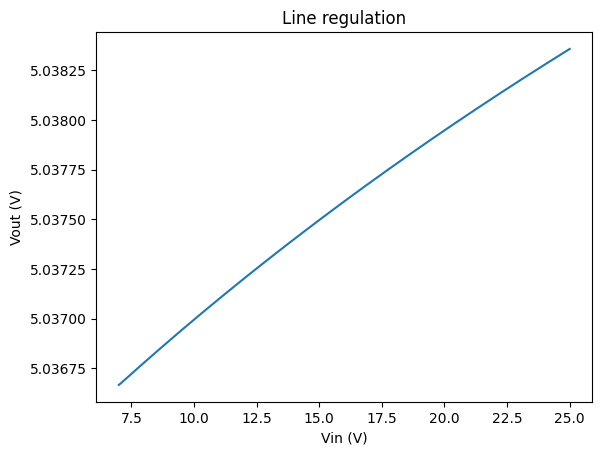

In [36]:
ng.cmd('dc v1 7 25 0.1')
vin = ng.vector('vin')
vout = ng.vector('out')
plt.plot(vin, vout)
plt.xlabel('Vin (V)')
plt.ylabel('Vout (V)')
plt.title('Line regulation')

In [37]:
delta = 1e3 * (vout[-1] - vout[0])
print('delta Vout = %.2f mV, ratio %.3f mV / V' % (delta, delta / (vin[-1] - vin[0])))

delta Vout = 1.69 mV, ratio 0.094 mV / V


### Load regulation

The datasheet says the typical $\Delta V_\mathrm{OUT}$ is 15mV when $I_\mathrm{OUT}$ changing from 5mA to 1.5A.
Our model is 7.6mV.

ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver


Text(0.5, 1.0, 'Load regulation')

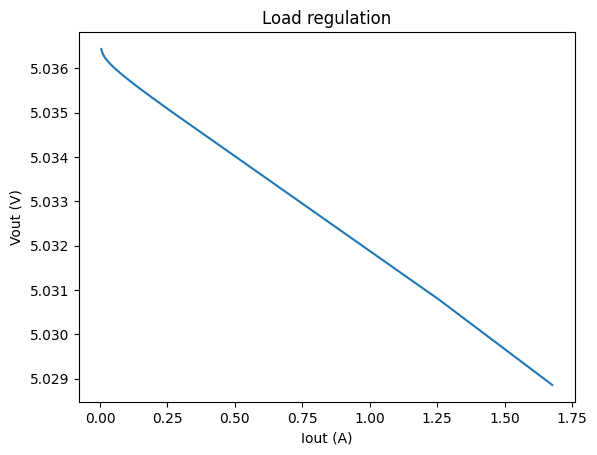

In [52]:
ng.cmd('dc rload 3 1000 1')
rload = ng.vector('res-sweep')
vout = ng.vector('out')
iout = vout / rload
plt.plot(iout, vout)
plt.xlabel('Iout (A)')
plt.ylabel('Vout (V)')
plt.title('Load regulation')

In [53]:
delta =  (vout[-1] - vout[0])
print('delta Vout = %.2f mV, Output resistance %.4f Ohm' % (1e3 * delta, delta / (iout[0] - iout[-1])))

delta Vout = 7.58 mV, Output resistance 0.0045 Ohm


### Startup circuit

* quiescent current is too large, almost 1mA is wasted.

ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver


Text(0, 0.5, 'Vout (V)')

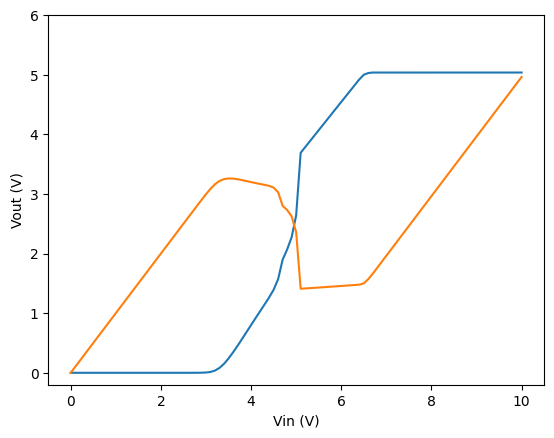

In [32]:
ng.cmd('dc v1 0 10 0.1')
vin = ng.vector('vin')
vout = ng.vector('out')
plt.plot(vin, vout)
plt.plot(vin, vin - vout)
plt.ylim(-0.2, 6)
plt.xlabel('Vin (V)')
plt.ylabel('Vout (V)')

In [33]:
for i in range(60, 71):
    print('Vin = %.2f V, Vout = %.3f V, Dropout %.2f V' % (vin[i], vout[i], vin[i] - vout[i]))

Vin = 6.00 V, Vout = 4.543 V, Dropout 1.46 V
Vin = 6.10 V, Vout = 4.638 V, Dropout 1.46 V
Vin = 6.20 V, Vout = 4.733 V, Dropout 1.47 V
Vin = 6.30 V, Vout = 4.827 V, Dropout 1.47 V
Vin = 6.40 V, Vout = 4.922 V, Dropout 1.48 V
Vin = 6.50 V, Vout = 5.000 V, Dropout 1.50 V
Vin = 6.60 V, Vout = 5.029 V, Dropout 1.57 V
Vin = 6.70 V, Vout = 5.037 V, Dropout 1.66 V
Vin = 6.80 V, Vout = 5.037 V, Dropout 1.76 V
Vin = 6.90 V, Vout = 5.037 V, Dropout 1.86 V
Vin = 7.00 V, Vout = 5.037 V, Dropout 1.96 V


### Fixing tempco

ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver


0.33500589559324734


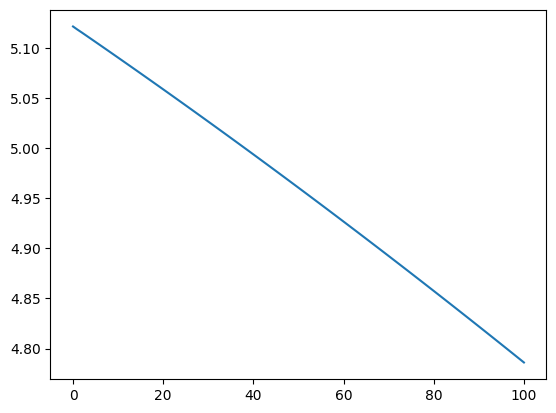

In [41]:
ng.cmd('dc temp 0 100 1')
temp = ng.vector('temp-sweep')
vout = ng.vector('out')
plt.plot(temp, vout)
print(max(vout) - min(vout))

ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver
ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver
ERROR:ngspyce.sharedspice:Note: Starting dynamic gmin stepping
ERROR:ngspyce.sharedspice:Note: Dynamic gmin stepping completed
ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver
ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver
ERROR:ngspyce.sharedspice:Note: Starting dynamic gmin stepping
ERROR:ngspyce.sharedspice:Note: Dynamic gmin stepping completed
ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver
ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver
ERROR:ngspyce.sharedspice:Note: Starting dynamic gmin stepping
ERROR:ngspyce.sharedspice:Note: Dynamic gmin stepping completed
ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver
ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver
ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver
ERROR:ngspyce.sh

R2 = 31 k, Vout@27C = 6.579 V, delta Vout =  167.9 mV
R2 = 30 k, Vout@27C = 6.433 V, delta Vout =  120.4 mV
R2 = 29 k, Vout@27C = 6.289 V, delta Vout =   73.1 mV
R2 = 28 k, Vout@27C = 6.145 V, delta Vout =   26.4 mV
R2 = 27 k, Vout@27C = 6.002 V, delta Vout =  -20.1 mV
R2 = 26 k, Vout@27C = 5.861 V, delta Vout =  -66.2 mV
R2 = 25 k, Vout@27C = 5.720 V, delta Vout = -112.0 mV
R2 = 24 k, Vout@27C = 5.581 V, delta Vout = -157.4 mV
R2 = 23 k, Vout@27C = 5.443 V, delta Vout = -202.4 mV
R2 = 22 k, Vout@27C = 5.306 V, delta Vout = -247.1 mV
R2 = 21 k, Vout@27C = 5.170 V, delta Vout = -291.2 mV
R2 = 20 k, Vout@27C = 5.036 V, delta Vout = -335.0 mV


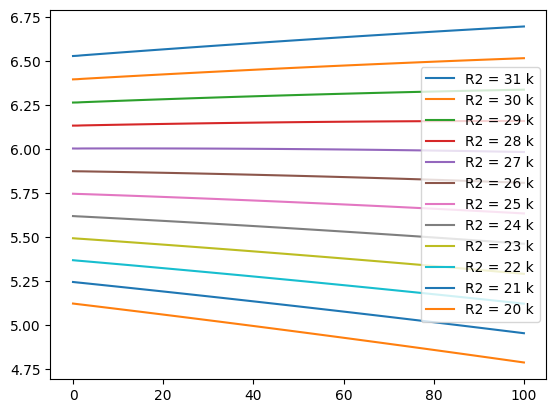

In [42]:
for r2 in range(31, 19, -1):
  ng.cmd('alter r2 %d' % (r2*1000))
  ng.cmd('dc temp 0 100 1')
  temp = ng.vector('temp-sweep')
  vout = ng.vector('out')
  plt.plot(temp, vout, label = 'R2 = %d k' % r2)
  print('R2 = %d k, Vout@27C = %.3f V, delta Vout = %6.1f mV' % (r2, vout[27], 1e3*(vout[-1] - vout[0])))
plt.legend()

In [43]:
# R2 was 20k
r2 = 27
ng.cmd('alter r2 %d' % (r2*1000))
print_op()

ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver


       out =  6002.43 mV
      q10e =  5309.48 mV
      q11b =  6736.01 mV
      q12b =  5514.02 mV
      q12c =  9631.36 mV
      q12e =  4849.91 mV
      q13b =  2387.65 mV
      q14b =   373.07 mV
      q17b =  6736.82 mV
      q17e =  6019.68 mV
       q1b =   692.90 mV
       q1c =  1314.85 mV
       q3b =   593.50 mV
       q4b =  1205.16 mV
       q5e =  3484.24 mV
       q6e =  4178.00 mV
       q8b =  9064.39 mV
       q8e =  9780.98 mV
       q9c =  7446.98 mV
       q9e =  9780.26 mV
        r3 =    84.28 mV
       ref =  4800.19 mV
 v1#branch = -66272.01 uA
       vin = 10000.00 mV


ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver


0.020429764616625157


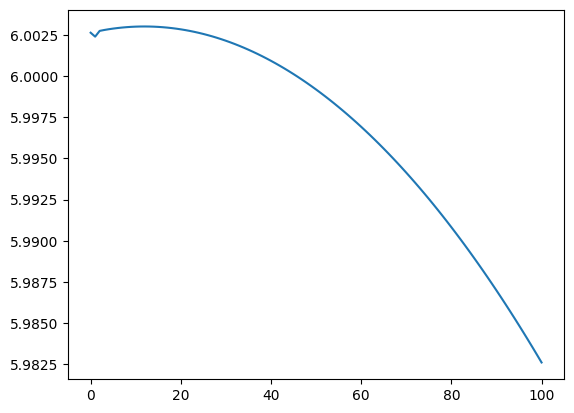

In [44]:
ng.cmd('dc temp 0 100 1')
temp = ng.vector('temp-sweep')
vout = ng.vector('out')
plt.plot(temp, vout)
print(max(vout) - min(vout))

Bring back the output voltage by adjusting $R_{20}$

ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver
ERROR:ngspyce.sharedspice:Note: Starting dynamic gmin stepping
ERROR:ngspyce.sharedspice:Note: Dynamic gmin stepping completed


0.01647117642314555


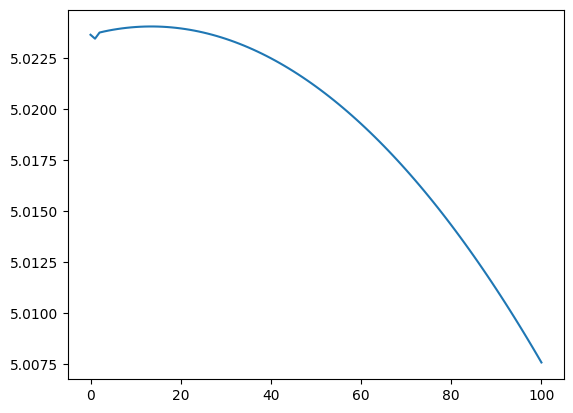

In [45]:
# R20 was 1.2k
ng.cmd('alter r20 230')
ng.cmd('dc temp 0 100 1')
temp = ng.vector('temp-sweep')
vout = ng.vector('out')
plt.plot(temp, vout)
print(max(vout) - min(vout))

## LM7805

### SPICE model

https://github.com/kafana/ltspice-misc/blob/master/models/regulators.lib